# What is the ratio estimator (neural network) looking at?

In [1]:
import corner
import glob
import hypothesis
import numpy as np
import matplotlib.pyplot as plt
import torch
import warnings

from hypothesis.stat import highest_density_level
from hypothesis.visualization.util import make_square
from matplotlib.colors import LogNorm
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from plotting import compute_1d_pdf
from plotting import compute_2d_pdf
from plotting import compute_1d_pdf_abc
from plotting import compute_2d_pdf_abc
from plotting import plot_1d_pdf
from plotting import plot_2d_pdf
from plotting import plot_1d_pdf_std
from plotting import plot_1d_contours
from plotting import plot_2d_contours
from plotting import plot_stream

from util import load_ratio_estimator
from tqdm import tqdm

In [2]:
datadir = "../experiment-simulations/data"       # Root directory containing the generated and observed data
phi = np.load(datadir + "/phi-cut.npy")          # Linear angle

In [3]:
query = "out/coverage/4096/marginalized/selu/ratio-estimator-resnet-50*/best-model.th"
r_1d = load_ratio_estimator(query)

In [4]:
def remove_impact(index, data):
    mapping = {
        0: remove_impact1,
        1: remove_impact2,
        2: remove_impact3,
        3: remove_impact4,
        4: remove_impact5}
    mapping[index](data)
    
def remove_impact1(data):
    # First impact
    data[6] += 0.2

def remove_impact2(data):
    # Second impact
    data[19] += 0.1
    data[20] += 0.1
    data[21] += 0.1
    data[22] += 0.1
    data[23] += 0.1
    data[24] += 0.1

def remove_impact3(data):
    # Thirth impact
    data[31] += 0.3
    data[32] += 0.3
    data[32] += 0.1

def remove_impact4(data):
    # Fourth impact
    data[42] += 0.3
    data[43] += 0.25
    data[45] += 0.25

def remove_impact5(data):
    # Fifth impact
    data[51] += 0.2
    data[52] += 0.4
    data[53] += 0.3
    data[54] += 0.25
    data[55] += 0.4
    data[56] += 0.1
    data[57] += 0.4
    data[58] += 0.2

In [5]:
impacts_phi = np.array([-28.5, -15.5, -8.65, 0, 6])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


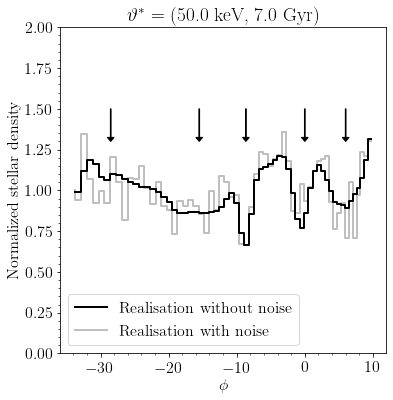

In [6]:
fig = plt.figure(figsize=(6, 6))

density_clean = np.load("../experiment-simulations/data/mock/block-00009/density-contrasts-cut.npy")
for x in impacts_phi:
    plt.arrow(x, 1.5, 0, -0.2, color="black", width=0.1, head_width=1, head_length=0.025, length_includes_head=True)
plt.step(phi, density_clean.reshape(-1), lw=2, color="black", alpha=1, label="Realisation without noise")
density = np.load("../experiment-simulations/data/mock/block-00009/density-contrasts-cut-noised.npy").reshape(-1)
plt.step(phi, density, lw=2, color="black", alpha=0.25, label="Realisation with noise")
plt.minorticks_on()
plt.ylabel("Normalized stellar density")
plt.xlabel(r"$\phi$")
plt.title(r"$\vartheta^*$ = (50.0 keV, 7.0 Gyr)")
plt.legend(loc="lower left")
plt.ylim([0, 2])
make_square(plt.gca())
#plt.tight_layout()
plt.savefig("plots/edge-case.pdf", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

In this notebook we are interested in examing whether the ratio estimator as learned to associated subhalo impacts of lower masses with CDM. To do so, we manually remove their effects by smoothening the observed stellar density of a stream.

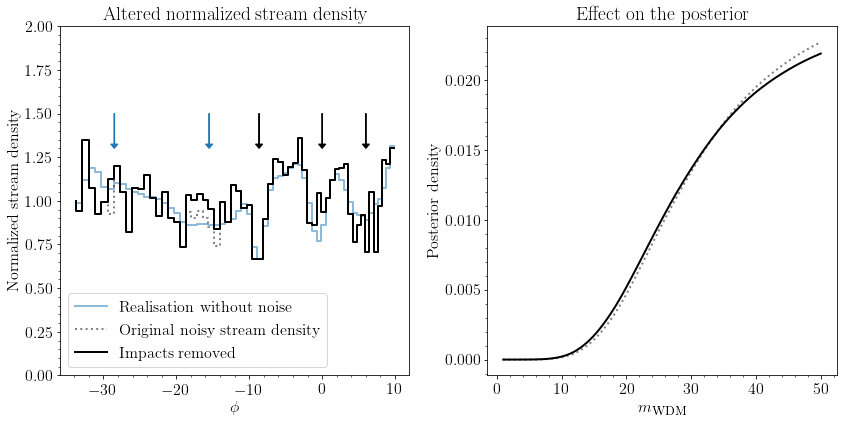

In [7]:
remove_impacts = [0,1]

def plot(remove_impacts, filename=None):
    figure, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Left plot
    ax = axes[0]
    for i, x in enumerate(impacts_phi):
        if i in remove_impacts:
            color = "C0"
        else:
            color = "black"
        ax.arrow(x, 1.5, 0, -0.2, color=color, width=0.1, head_width=1, head_length=0.025, length_includes_head=True)
    density = np.load("../experiment-simulations/data/mock/block-00009/density-contrasts-cut-noised.npy").reshape(-1)
    original = np.array(density)
    # Remove the effects of the impacts
    new = np.array(density)
    for i in remove_impacts:
        remove_impact(i, new)

    density_clean = np.load("../experiment-simulations/data/mock/block-00009/density-contrasts-cut.npy")
    ax.step(phi, density_clean.reshape(-1), lw=2, color="C0", alpha=0.5, label="Realisation without noise")
    ax.step(phi, original, lw=2, linestyle=':', color="black", alpha=0.5, label="Original noisy stream density")
    ax.step(phi, new, lw=2, color="black", alpha=1, label="Impacts removed")
    ax.minorticks_on()
    ax.set_title("Altered normalized stream density")
    ax.set_ylabel("Normalized stream density")
    ax.set_xlabel(r"$\phi$")
    ax.set_ylim([0, 2])
    ax.legend(loc="lower left")
    make_square(ax)

    # Right plot
    ax = axes[1]
    o = torch.from_numpy(original.reshape(1, -1)).float()
    o /= o.mean() # Ensure normalized density
    pdf_original, _ = compute_1d_pdf(r_1d, o)
    space = np.linspace(1, 50, 100)
    pdf_original /= np.sum(pdf_original)

    o = torch.from_numpy(new.reshape(1, -1)).float()
    o /= o.mean() # Ensure normalized density
    pdf_new, _ = compute_1d_pdf(r_1d, o)
    pdf_new /= np.sum(pdf_new)
    ax.minorticks_on()
    ax.set_xlabel(r"$m_\textsc{wdm}$")
    ax.set_ylabel("Posterior density")
    ax.set_title("Effect on the posterior")

    ax.plot(space, pdf_original, linestyle=':', lw=2, color="black", alpha=.5, label="Original noisy stream density")
    ax.plot(space, pdf_new, lw=2, color="black", label="Impacts removed from stream density")
    make_square(ax)
    if filename is not None:
        figure.tight_layout()
        figure.savefig(filename, bbox_inches='tight', transparent=True, pad_inches=0)
    plt.show()
    
plot(remove_impacts, filename="plots/edge-case-remove-01.pdf")

In this case, the posterior remains unaffected if we remove subhalo impacts below the noise level.

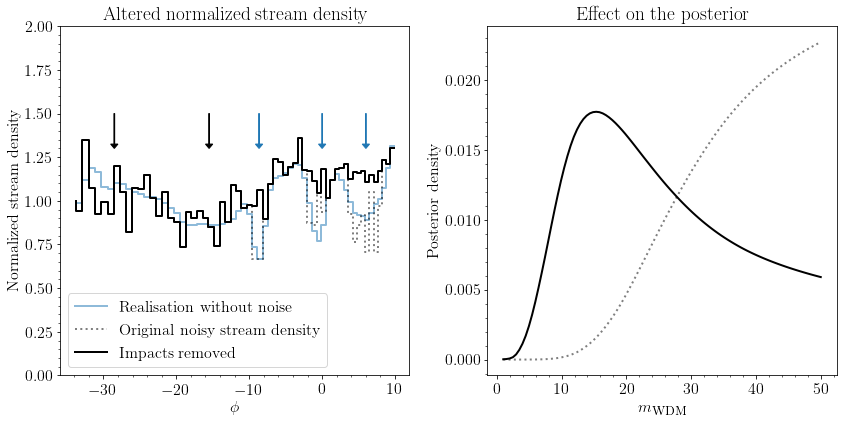

In [8]:
remove_impacts = [2,3,4]

def plot(remove_impacts, filename=None):
    figure, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Left plot
    ax = axes[0]
    for i, x in enumerate(impacts_phi):
        if i in remove_impacts:
            color = "C0"
        else:
            color = "black"
        ax.arrow(x, 1.5, 0, -0.2, color=color, width=0.1, head_width=1, head_length=0.025, length_includes_head=True)
    density = np.load("../experiment-simulations/data/mock/block-00009/density-contrasts-cut-noised.npy").reshape(-1)
    original = np.array(density)
    # Remove the effects of the impacts
    new = np.array(density)
    for i in remove_impacts:
        remove_impact(i, new)

    density_clean = np.load("../experiment-simulations/data/mock/block-00009/density-contrasts-cut.npy")
    ax.step(phi, density_clean.reshape(-1), lw=2, color="C0", alpha=0.5, label="Realisation without noise")
    ax.step(phi, original, lw=2, linestyle=':', color="black", alpha=0.5, label="Original noisy stream density")
    ax.step(phi, new, lw=2, color="black", alpha=1, label="Impacts removed")
    ax.minorticks_on()
    ax.set_title("Altered normalized stream density")
    ax.set_ylabel("Normalized stream density")
    ax.set_xlabel(r"$\phi$")
    ax.set_ylim([0, 2])
    ax.legend(loc="lower left")
    make_square(ax)

    # Right plot
    ax = axes[1]
    o = torch.from_numpy(original.reshape(1, -1)).float()
    o /= o.mean() # Ensure normalized density
    pdf_original, _ = compute_1d_pdf(r_1d, o)
    space = np.linspace(1, 50, 100)
    pdf_original /= np.sum(pdf_original)

    o = torch.from_numpy(new.reshape(1, -1)).float()
    o /= o.mean() # Ensure normalized density
    pdf_new, _ = compute_1d_pdf(r_1d, o)
    pdf_new /= np.sum(pdf_new)
    ax.minorticks_on()
    ax.set_xlabel(r"$m_\textsc{wdm}$")
    ax.set_ylabel("Posterior density")
    ax.set_title("Effect on the posterior")

    ax.plot(space, pdf_original, linestyle=':', lw=2, color="black", alpha=.5, label="Original noisy stream density")
    ax.plot(space, pdf_new, lw=2, color="black", label="Impacts removed from stream density")
    make_square(ax)
    if filename is not None:
        figure.tight_layout()
        figure.savefig(filename, bbox_inches='tight', transparent=True, pad_inches=0)
    plt.show()
    
plot(remove_impacts, filename="plots/edge-case-remove-234.pdf")

This is not the case for subhalo impacts of higher masses. Sadly, we did not record the masses of the subhalo impacts during the simulation. This would allow us to probe the sensitivity of our methodology within the assumed simulation model. In addition, these results show that the proposed methodology correctly assigned these smaller subhalo impacts to CDM.